 Код взят из https://habr.com/ru/articles/726254/ и исправлен под новую версию pytorch_lightning

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import pytorch_lightning as pl
import numpy as np
from matplotlib import pyplot as plt, gridspec

Загрузим датасет MNIST

In [2]:
mnist_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=0.5, std=0.5),
                                       transforms.Lambda(lambda x: x.view(-1, 784))])

data = datasets.MNIST(root='MNIST', download=True, transform=mnist_transforms)

mnist_dataloader = DataLoader(data, batch_size=128, shuffle=True, num_workers=4)

Определим классы генератора и дискриминатора

In [3]:
class Generator(nn.Module):
    '''
    Generator class. Accepts a tensor of size 100 as input as outputs another
    tensor of size 784. Objective is to generate an output tensor that is
    indistinguishable from the real MNIST digits 
    '''

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_features=100, out_features=256),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(in_features=256, out_features=512),
                                    nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(in_features=512, out_features=1024),
                                    nn.ReLU())
        self.output = nn.Sequential(nn.Linear(in_features=1024, out_features=28*28),
                                nn.Tanh())

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output(x)
        return x

In [4]:
class Discriminator(nn.Module):
    '''
    Discriminator class. Accepts a tensor of size 784 as input and outputs
    a tensor of size 1 as  the predicted class probabilities
    (generated or real data)
    '''

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_features=28*28, out_features=1024),
                                    nn.LeakyReLU())
        self.layer2 = nn.Sequential(nn.Linear(in_features=1024, out_features=512),
                                    nn.LeakyReLU())
        self.layer3 = nn.Sequential(nn.Linear(in_features=512, out_features=256),
                                    nn.LeakyReLU())
        self.output = nn.Sequential(nn.Linear(in_features=256, out_features=1),
                                    nn.Sigmoid())

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output(x)
        return x

Напишем класс GAN для обучения через pytorch_lightning

In [5]:
class GAN(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.generator = Generator()
        self.discriminator = Discriminator()
        # After each epoch, we generate 100 images using the noise
        # vector here (self.test_noises). We save the output images
        # in a list (self.test_progression) for plotting later.
        self.test_noises = torch.randn(100, 1, 100, device=device)
        self.test_progression = []

    def forward(self, z):
        """
        Generates an image using the generator
        given input noise z
        """
        return self.generator(z)

    def generator_step(self, x):
        """
        Training step for generator
        1. Sample random noise
        2. Pass noise to generator to
           generate images
        3. Classify generated images using
           the discriminator
        4. Backprop loss to the generator
        """

        # Sample noise
        z = torch.randn(x.shape[0], 1, 100, device=device)

        # Generate images
        generated_imgs = self(z)

        # Classify generated images
        # using the discriminator
        d_output = torch.squeeze(self.discriminator(generated_imgs))

        # Backprop loss. We want to maximize the discriminator's
        # loss, which is equivalent to minimizing the loss with the true
        # labels flipped (i.e. y_true=1 for fake images). We do this
        # as PyTorch can only minimize a function instead of maximizing
        g_loss = nn.BCELoss()(d_output,
                               torch.ones(x.shape[0], device=device))

        return g_loss

    def discriminator_step(self, x):
        """
        Training step for discriminator
        1. Get actual images
        2. Predict probabilities of actual images and get BCE loss
        3. Get fake images from generator
        4. Predict probabilities of fake images and get BCE loss
        5. Combine loss from both and backprop loss to discriminator
        """

        # Real images
        d_output = torch.squeeze(self.discriminator(x))
        loss_real = nn.BCELoss()(d_output,
                                 torch.ones(x.shape[0], device=device))

        # Fake images
        z = torch.randn(x.shape[0], 1, 100, device=device)
        generated_imgs = self(z)
        d_output = torch.squeeze(self.discriminator(generated_imgs))
        loss_fake = nn.BCELoss()(d_output,
                                 torch.zeros(x.shape[0], device=device))

        return loss_real + loss_fake

    def training_step(self, batch, batch_idx):
        X, _ = batch
        
        # train generator
        loss = self.generator_step(X)
        loss.backward()
        self.g_optimizer.step()
        self.g_optimizer.zero_grad()
                
        # train discriminator
        loss = self.discriminator_step(X)      
        loss.backward()
        self.d_optimizer.step()
        self.d_optimizer.zero_grad()
        
        return loss

    def on_train_epoch_end(self):
        epoch_test_images = self(self.test_noises)
        self.test_progression.append(epoch_test_images)
        
    def configure_optimizers(self):
        self.automatic_optimization = False
        self.g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.0002)
        self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002)
        
        # Useless optimizer
        return torch.optim.Adam(self.parameters(), lr=0)

Обучаем модель на 100 эпохах

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = GAN()

trainer = pl.Trainer(max_epochs=100, logger=True)
trainer.fit(model, mnist_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/anton/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 1.5 M 
1 | discriminator | Discriminator | 1.5 M 
------------------------------------------------
2.9 M     Trainable params
0         Non-train

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Посмотрим на выход дикриминатора на последней эпохе

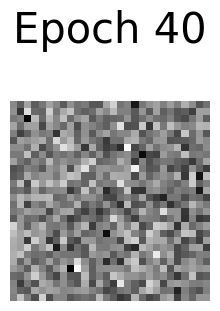

In [10]:
# Convert images from torch tensor to numpy array
images = [i.detach().cpu().numpy() for i in model.test_progression]

epoch_to_plot = 40

nrow = 1
ncol = 1

# randomly select 10 images for plotting
indexes = np.random.choice(range(100), nrow*ncol, replace=False)

fig = plt.figure(figsize=((ncol+1)*2, (nrow+1)*2)) 
fig.suptitle('Epoch {}'.format(epoch_to_plot), fontsize=30)

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

for i in range(nrow):
    for j in range(ncol):
        idx = i*ncol + j
        img = np.reshape(images[epoch_to_plot-1][indexes[idx]], (28,28))
        ax = plt.subplot(gs[i,j])
        ax.imshow(img, cmap='gray')
        ax.axis('off')

Видно, что модель не научилась генерировать похожие на цифры картинки. Это произошло из-за того, что мы не учитывали необходимый для генерации класс (значение цифры) и модель посчитала эту картинку более похожей на любой класс цифры.